# Лабораторная работа 2. Вероятностные модели.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 15 баллов. Также в результате выполнения заданий у вас получится решение [задачи конкурса](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2021), которое после небольшой доработки принесёт ещё 5 баллов за пробитие Medium Baseline.
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировками
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.


Цель этой лабораторной работы – научиться строить вероятностные модели и оптимизировать их параметры на примере задачи оценки риска заболевания сахарным диабетом. На задачу оценки риска болезни мы посмотрим со стороны страховой компании.

Если человек перестанет проходить обследования, и страховая так и не узнает, развился ли у него диабет, то и расходов, связанных с его заболеванием не будет, т.е. можно считать, что такой человек остался здоров. То же касается людей, у которых заболевание впервые обнаружат более чем через 5 лет.

Чтобы рассчитать математическое ожидание затрат на лечение клиента, страховая хочет получить в качестве результата работы модели непосредственно вероятность того, что у человека, не страдающего от заболевания, оно разовьётся в течение 5 лет. Поэтому в качестве метрики качества была выбрана бинарная кросс-энтропия (она же logloss) между предсказанными вероятностями и истинными метками классов:


$$\text{crossentropy}(y, p) = -\frac{1}{N}\sum_{i=1}^N\left[y_i\log(p_i) + (1-y_i)\log(1-p_i)\right]$$



In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3)

**Задание 1** Препроцессинг (1 балл) 

- Прочитайте описание [набора данных и задачи конкурса 2](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2021).
- Загрузите обучающий набор данных (X_train.csv, y_train.csv).
- Обратите внимание, что часть информации о клиентах неизвестна на момент заключения договора. Соответствующие признаки отсутствуют в X_test.csv.
- Заполните пропуски в данных. Для этого могут пригодиться методы из sklearn.impute или pandas.DataFrame.fillna.
- По желанию используйте любой препроцессинг данных, добавляйте новые признаки и т.п. ваша задача — добиться сходимости и высокого качества полученных моделей.
- Разбейте обучающую выборку на lab_train и lab_test, которые будете использовать для оценки всех построенных моделей в лабораторной работе. При желании использовать для оценки качества кросс-валидацию необходимо проконтролировать, чтобы для всех моделей использовались одни и те же разбиения.

Загрузим датасеты

In [2]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")["diabettes in 5 years"]
X_test = pd.read_csv("X_test.csv")

In [3]:
X_train.head()

,Age,Gender,site,height,weight,Body Mass Index,Systolic blood pressure,diastolic blood pressure,Fasting plasma glucose,Cholesterol,...,Aspartate transaminase,Blood urea nitrogen,Creatinine clearance rate,Fasting plasma glucose (final visit),Diabetes diagnosed during followup,censor of diabetes at followup,year of followup,smoking status,drinking status,family history of diabetes
0,53,1,13,163.5,64.1,24.00,106.0,68.0,4.83,3.84,...,NaN,5.01,74.8,5.23,NaN,0,2.699521,3.0,3.0,0
1,26,2,3,156.0,68.5,28.10,98.0,68.0,5.12,4.12,...,15.3,3.19,54.7,4.33,NaN,0,2.187543,3.0,3.0,0
2,40,2,5,152.0,47.0,20.30,111.0,63.0,5.62,4.30,...,17.0,4.38,66.0,4.70,NaN,0,2.042437,3.0,3.0,0
3,34,1,4,177.0,68.0,21.71,133.0,81.0,4.84,4.35,...,26.5,5.79,78.9,5.69,NaN,0,2.028747,NaN,NaN,0
4,34,1,3,178.0,68.0,21.50,124.0,84.0,3.73,5.02,...,NaN,3.68,76.9,5.00,NaN,0,4.950034,3.0,3.0,0


In [4]:
X_test.head()

,Age,Gender,site,height,weight,Body Mass Index,Systolic blood pressure,diastolic blood pressure,Fasting plasma glucose,Cholesterol,Triglyceride,High-density lipoprotein cholesterol,Low-density lipoprotein cholesterol,Alanine aminotransferase,Aspartate transaminase,Blood urea nitrogen,Creatinine clearance rate,smoking status,drinking status,family history of diabetes
0,67,2,3,159.0,65.5,25.9,139.0,65.0,3.79,6.33,2.07,NaN,NaN,16.0,NaN,4.88,67.4,3.0,3.0,0
1,27,1,5,177.0,80.0,25.5,105.0,62.0,5.64,5.00,1.40,NaN,NaN,57.0,NaN,5.89,84.0,NaN,NaN,0
2,65,2,2,158.0,53.0,21.2,108.0,67.0,4.76,5.37,1.85,NaN,NaN,13.6,20.4,4.25,59.1,NaN,NaN,0
3,30,1,6,173.5,69.0,22.9,111.0,76.0,5.20,4.82,1.06,1.4,2.8,48.8,NaN,4.40,70.2,NaN,NaN,0
4,25,1,5,173.0,71.0,23.7,112.0,67.0,4.73,3.88,0.89,NaN,NaN,21.0,25.0,6.57,81.0,NaN,NaN,0


In [5]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: diabettes in 5 years, dtype: int64

Сразу разделим признаки на категориальные и числовые, чтобы было удобнее работать

In [6]:
columns = [col for col in X_train.columns if col in X_test.columns]
columns

['Age',
 'Gender',
 'site',
 'height',
 'weight',
 'Body Mass Index',
 'Systolic blood pressure',
 'diastolic blood pressure',
 'Fasting plasma glucose',
 'Cholesterol',
 'Triglyceride',
 'High-density lipoprotein cholesterol ',
 'Low-density lipoprotein cholesterol',
 'Alanine aminotransferase',
 'Aspartate transaminase',
 'Blood urea nitrogen',
 'Creatinine clearance rate',
 'smoking status',
 'drinking status',
 'family history of diabetes']

In [7]:
for col in columns:
    print(col, X_train[col].unique())

Age [53 26 40 34 37 57 67 32 46 29 44 38 52 27 35 31 47 49 33 50 58 30 64 45
 28 42 59 56 39 36 75 41 60 68 65 51 76 48 71 43 66 61 54 62 55 73 25 70
 79 24 63 81 23 84 78 69 77 22 80 74 92 85 72 82 83 87 88 93 91 89 86 21
 95 20 99 90 97 94]
Gender [1 2]
site [13  3  5  4  7  8  9  2 12 14 11 10 16  6  0]
height [163.5 156.  152.  177.  178.  169.5 163.  170.  168.  162.  171.  159.
 183.6 169.  166.  165.5 158.9 184.1 172.  154.3 164.9 158.5 174.  167.
 173.5 184.  176.  149.  186.8 180.  158.  165.  164.  153.4 175.  178.3
 157.  167.9 160.4 164.5 162.2 159.5 160.5 161.3 181.  174.5 153.  177.5
 154.  171.8 179.  159.2 176.1 161.  155.  162.5 151.5 172.5 157.8 160.
 166.5 150.5 169.9 185.5 165.6 173.  184.5 161.5 155.5 156.5 177.1 183.5
 176.5 164.4 157.5 171.5 149.1 182.5 168.3 167.5 152.5 167.6 163.2 180.5
 168.5 187.  169.6 175.5 182.  153.9 164.1 151.  158.3 153.5 191.3 175.7
 170.5 157.3 150.  178.5 157.1 164.3 175.4 170.2 148.  160.2 185.  157.4
 160.7 181.5 163.1 174.9 153.7 

In [8]:
categorial = ['Gender', 'site', 'smoking status', 'drinking status', 'family history of diabetes']
numerical = ['Age', 'height', 'weight', 'Body Mass Index', 'Systolic blood pressure', 'diastolic blood pressure', 'Fasting plasma glucose', 'Cholesterol', 'Triglyceride', 'High-density lipoprotein cholesterol ', 'Low-density lipoprotein cholesterol', 'Alanine aminotransferase', 'Aspartate transaminase', 'Blood urea nitrogen', 'Creatinine clearance rate']
assert set(categorial + numerical) == set(columns)

### Устранение пропусков

Посмотрим на пропуски в категориальных признаках:

In [9]:
np.mean(X_train[categorial].isnull())

Gender                        0.00000
site                          0.00000
smoking status                0.71412
drinking status               0.71412
family history of diabetes    0.00000
dtype: float64

Выбрасывать признаки из рассмотрения плохо - они могут влиять на заболеваемость. С другой стороны, заполнить все пропуски константным значением (все "пил(а)/курил(а)" или все "не пил(а)/не курил(а)") не сильно лучше, так как это может сильно повлиять на достоверность результатов. Заполним False, но будем помнить, что это имело место.

In [10]:
X_train[categorial] = X_train[categorial].fillna(3.)

Проанализируем теперь числовые признаки

In [11]:
np.mean(X_train[numerical].isnull())

Age                                      0.00000
height                                   0.00002
weight                                   0.00000
Body Mass Index                          0.00000
Systolic blood pressure                  0.00011
diastolic blood pressure                 0.00012
Fasting plasma glucose                   0.00000
Cholesterol                              0.02257
Triglyceride                             0.02277
High-density lipoprotein cholesterol     0.44444
Low-density lipoprotein cholesterol      0.43884
Alanine aminotransferase                 0.00837
Aspartate transaminase                   0.58247
Blood urea nitrogen                      0.10080
Creatinine clearance rate                0.05200
dtype: float64

Заметим, что очень много пропусков в описании lipoprotein cholesterol и Aspartate transaminase. Заполнять средними значениями не лучшая идея, попробуем выразить эти признаки через другие. Для этого исследуем корреляцию признаков:

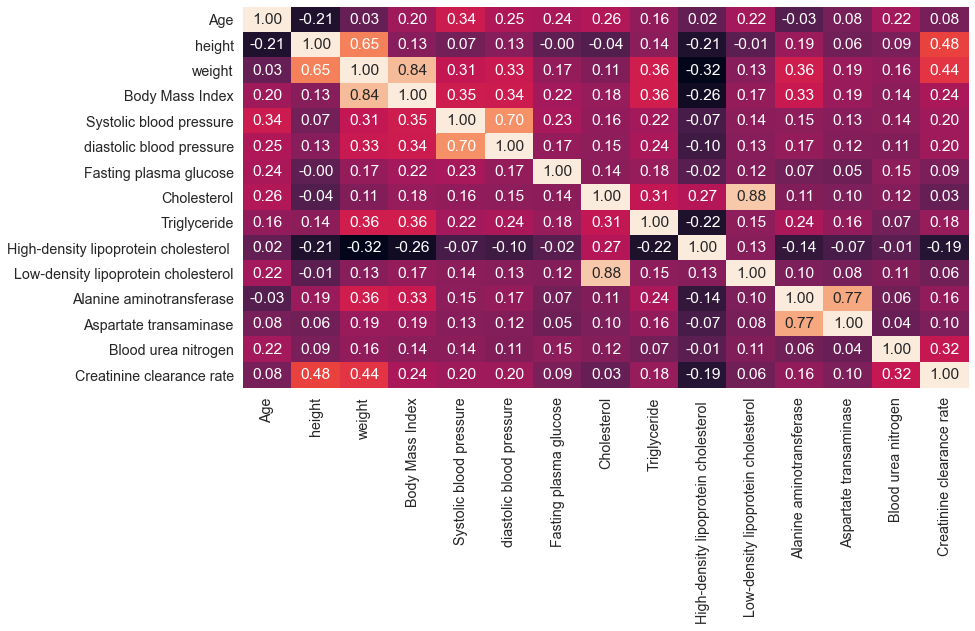

In [13]:
plt.figure(figsize=(13, 7))
sns.heatmap(round(X_train[numerical].dropna().corr(), 2), annot=True, fmt=".2f", cbar=False)
plt.show()

Заметим, что:
- Low-density lipoprotein cholesterol и Cholesterol скоррелированы (0.88)
- Alanine aminotransferase и Aspartate transaminase скоррелированы (0.77)
поэтому можно смело выбрасывать из рассмотрения соответствующие признаки

In [14]:
X_train.drop(columns=["Low-density lipoprotein cholesterol", "Aspartate transaminase"], inplace=True)
X_test.drop(columns=["Low-density lipoprotein cholesterol", "Aspartate transaminase"], inplace=True)
numerical.remove("Low-density lipoprotein cholesterol")
numerical.remove("Aspartate transaminase")
columns.remove("Low-density lipoprotein cholesterol")
columns.remove("Aspartate transaminase")

Заполним оставшиеся признаки средними значениями. Но перед этим проведём проверку на выбросы

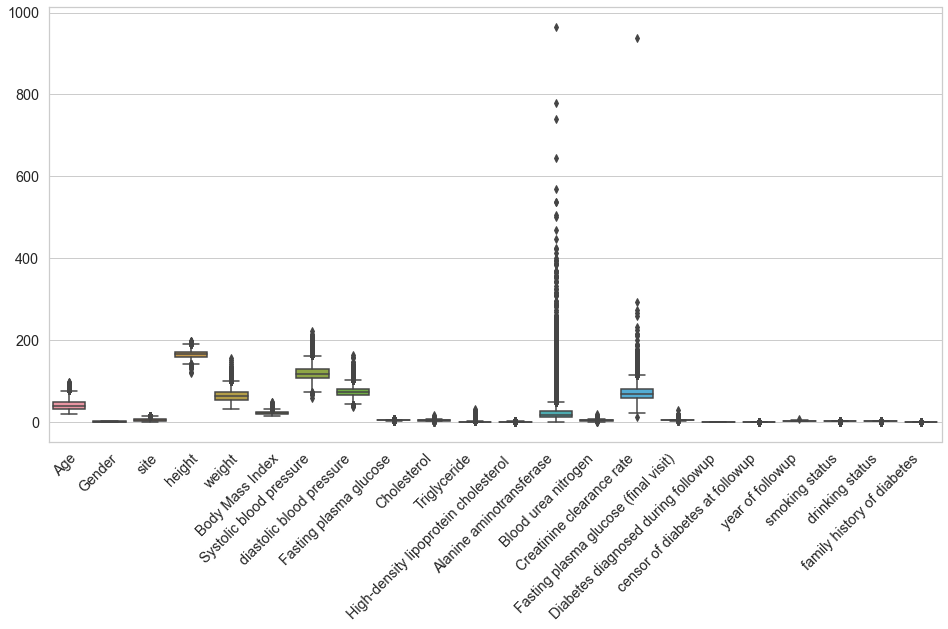

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
sns.boxplot(data=X_train)
plt.show()

Замечены аномалии в `Alanine aminotransferase` и `Creatinine clearance rate`. Рассмотрим поближе

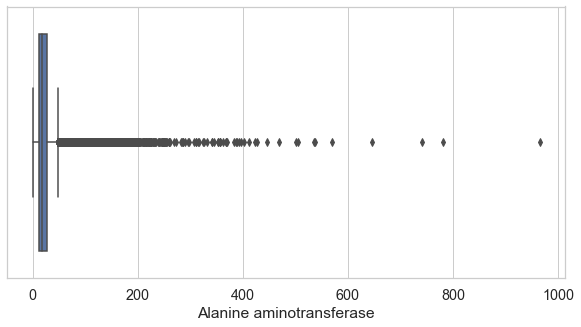

In [16]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=X_train["Alanine aminotransferase"])
plt.show()

Данные `Alanine aminotransferase` слабо напоминают выбросы, лучше оставить как есть

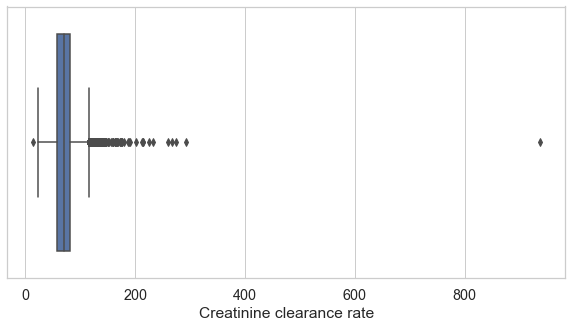

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=X_train["Creatinine clearance rate"])
plt.show()

In [18]:
X_train[X_train["Creatinine clearance rate"] > 800]

,Age,Gender,site,height,weight,Body Mass Index,Systolic blood pressure,diastolic blood pressure,Fasting plasma glucose,Cholesterol,...,Alanine aminotransferase,Blood urea nitrogen,Creatinine clearance rate,Fasting plasma glucose (final visit),Diabetes diagnosed during followup,censor of diabetes at followup,year of followup,smoking status,drinking status,family history of diabetes
89715,75,1,8,167.0,76.5,27.4,132.0,74.0,4.5,4.04,...,13.0,NaN,936.8,4.63,NaN,0,3.540041,3.0,3.0,0


In [19]:
X_train.drop(index=89715, inplace=True)
y_train.drop(index=89715, inplace=True)

Заполняем оставшиеся пропуски

In [20]:
X_train.fillna(X_train.mean(), inplace=True)

In [21]:
np.mean(X_train[columns].isnull())

Age                                      0.0
Gender                                   0.0
site                                     0.0
height                                   0.0
weight                                   0.0
Body Mass Index                          0.0
Systolic blood pressure                  0.0
diastolic blood pressure                 0.0
Fasting plasma glucose                   0.0
Cholesterol                              0.0
Triglyceride                             0.0
High-density lipoprotein cholesterol     0.0
Alanine aminotransferase                 0.0
Blood urea nitrogen                      0.0
Creatinine clearance rate                0.0
smoking status                           0.0
drinking status                          0.0
family history of diabetes               0.0
dtype: float64

Разобьём выборку на lab_train и lab_test

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_lab_train, X_lab_test, y_lab_train, y_lab_test = train_test_split(X_train, y_train, test_size=0.2)

**Задание 2** Бэйзлайн – константное предсказание (0.5 балла).

Как понять, работает ли та или иная модель, если сравить метрику не с чем? Чтобы было с чем сравнивать, соберём простой бэйзлайн: предскажем всем клиентам одну и ту же вероятность заболеть в течение 5 лет. Какое значение надо предсказать, чтобы минимизировать кросс-энтропию? Оцените качество такого предсказания.

In [24]:
from scipy.optimize import minimize_scalar

In [25]:
def cross_entropy(p, q):
    return -np.mean(q * np.log(p) + (1 - q) * np.log(1 - p))

In [26]:
min_prob = minimize_scalar(cross_entropy, bounds=(0, 1), args=(y_lab_train), tol=1e-6, method='bounded')
min_prob

/Users/gcsquar/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


     fun: 0.09244113877615245
 message: 'Solution found.'
    nfev: 18
  status: 0
 success: True
       x: 0.018575167431579043

Минимум кросс-энтропии:

In [27]:
cross_entropy(min_prob.x, y_lab_test.values)

0.09214267914846092

**Задание 3** Наивный байесовский классификатор (0.5 балла).

Предположим, что в каждом из классе признаки независимы и имеют нормальное распределение. Тогда подобрать параметры этого распределения поможет модель [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). Обучите эту модель. Оцените её качество.





In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, log_loss

In [29]:
gnb = GaussianNB().fit(X_lab_train[numerical], y_lab_train)

y_pred_gnb = gnb.predict(X_lab_test[numerical])
y_pred_proba_gnb = gnb.predict_proba(X_lab_test[numerical])

print("accuracy =", np.sum(y_pred_gnb == y_lab_test) / y_pred_gnb.size)
print("f1_score =", f1_score(y_lab_test, y_pred_gnb))
print("log_loss =", log_loss(y_lab_test, y_pred_proba_gnb))

accuracy = 0.93665
f1_score = 0.2297872340425532
log_loss = 0.3219975723122969


**Задание 4** Дискриминантный анализ (1 балл).

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_lda_qda_001.png)

Теперь избавимся от предположения условной независимости признаков относительно целевой переменной. Таким образом, ковариационные матрицы распределений классов не обязательно будут даигональны. Мы можем наложить дополнительное условие в виде [равенства ковариационных матриц](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis) всех классов или [не делать этого](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis).

Попробуйте оба варианта. Какой сработал лучше и чем это можно объяснить?


In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [31]:
lda = LinearDiscriminantAnalysis().fit(X_lab_train[numerical], y_lab_train)

y_pred_lda = lda.predict(X_lab_test[numerical])
y_pred_proba_lda = lda.predict_proba(X_lab_test[numerical])

print("accuracy =", np.sum(y_pred_lda == y_lab_test) / y_pred_lda.size)
print("f1_score =", f1_score(y_lab_test, y_pred_lda))
print("log_loss =", log_loss(y_lab_test, y_pred_proba_lda))

accuracy = 0.98095
f1_score = 0.25147347740667975
log_loss = 0.06297351188986118


In [32]:
qda = QuadraticDiscriminantAnalysis().fit(X_lab_train[numerical], y_lab_train)

y_pred_qda = qda.predict(X_lab_test[numerical])
y_pred_proba_qda = qda.predict_proba(X_lab_test[numerical])

print("accuracy =", np.sum(y_pred_qda == y_lab_test) / y_pred_qda.size)
print("f1_score =", f1_score(y_lab_test, y_pred_qda))
print("log_loss =", log_loss(y_lab_test, y_pred_proba_qda))

accuracy = 0.95225
f1_score = 0.19815281276238456
log_loss = 0.2722831247577715


Проанализируем результаты. По всем трём метрикам модель с предположением равенства ковариационных матриц лучше модели, которая этого не предполагает. Скорее всего, это из-за того, что среди признаков действительно есть подмножество признаков, нескоррелированных между собой и корректно дискриминирующих классы. Поэтому модель LinearDiscriminantAnalysis работает лучше как частный случай QuadraticDiscriminantAnalysis

**Задание 5** Логистическая регрессия (1 балл).

Обучите модель логистической регрессии. Убедитесь, что модель сошлась. Удалось ли получить улучшение по сравнению с предыдущими моделями? Чем это можно объяснить?

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve, KFold

In [36]:
lr = LogisticRegression(max_iter=500)
parametres = {'C': np.concatenate((np.linspace(0.0001, 0.05, 30), np.linspace(0.05, 2, 10)))}
train_scores, val_scores = validation_curve(lr, X_lab_train[numerical], y_lab_train, param_name='C', param_range=parametres['C'], cv=KFold(n_splits=3), scoring='neg_log_loss', n_jobs=-1)

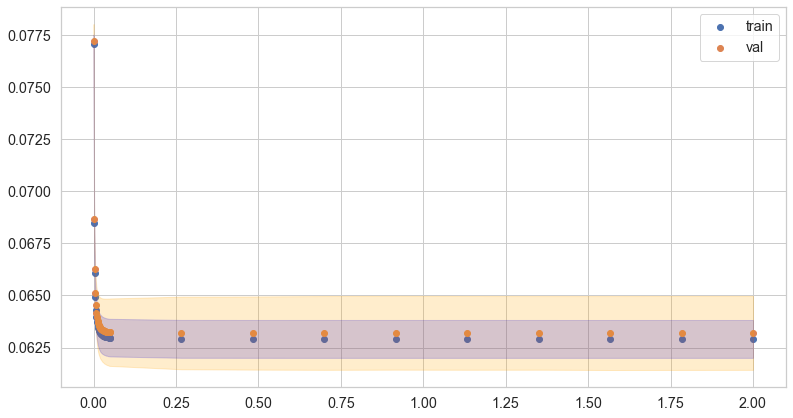

In [37]:
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(13, 7))
plt.scatter(parametres['C'], train_scores_mean, label='train')
plt.fill_between(parametres['C'], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                color="blue", alpha=0.2)
plt.scatter(parametres['C'], val_scores_mean, label='val')
plt.fill_between(parametres['C'], val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, 
                color="orange", alpha=0.2)
plt.legend()
plt.show()


In [43]:
lr = LogisticRegression(max_iter=500, C=0.5).fit(X_lab_train[numerical], y_lab_train)

y_pred_lr = lr.predict(X_lab_test[numerical])
y_pred_proba_lr = lr.predict_proba(X_lab_test[numerical])

print("accuracy =", np.sum(y_pred_lr == y_lab_test) / y_pred_lr.size)
print("f1_score =", f1_score(y_lab_test, y_pred_lr))
print("log_loss =", log_loss(y_lab_test, y_pred_proba_lr))

accuracy = 0.98175
f1_score = 0.14918414918414918
log_loss = 0.0615382415172513


Сильного улучшения по сравнению с предыдущими моделями не получили

**Задание 6** GLM – обобщённые линейные модели (1 балл).

Как вы знаете, логистическая регрессия является частным случаем обобщённой линейной модели $\mu(\mathbb E(y|X)) = Xw$, где функция связи $\mu(u) = \log(\frac{u}{1-u})$, и $y|X\sim Bernoulli$.

Учитывая, что целевая переменная бинарная, изменять класс распределений $y|X$ не имеет смысла. А вот изменить функцию связи можно.

Обучите обобщённые линейные модели, в качестве функции связи использовав по крайней мере 2 разные функции, отличные от logit, использующейся в логистической регрессии.

Реализацию GLM можно взять в пакете [statsmodels](https://www.statsmodels.org/stable/glm).



In [44]:
import statsmodels
from statsmodels import api as sm

In [45]:
glm_cloglog = sm.GLM(y_lab_train, X_lab_train[numerical], family=sm.families.Binomial(link=sm.families.links.cloglog()))
model_cloglog = glm_cloglog.fit()
print(model_cloglog.summary())

y_pred_cloglog = model_cloglog.predict(X_lab_test[numerical])
print("log_loss =", log_loss(y_lab_test, y_pred_cloglog))

                  Generalized Linear Model Regression Results                   
Dep. Variable:     diabettes in 5 years   No. Observations:                79999
Model:                              GLM   Df Residuals:                    79986
Model Family:                  Binomial   Df Model:                           12
Link Function:                  cloglog   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -5063.7
Date:                  Thu, 01 Jul 2021   Deviance:                       10127.
Time:                          05:14:05   Pearson chi2:                 1.04e+05
No. Iterations:                      11                                         
Covariance Type:              nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

In [46]:
glm_cauchy = sm.GLM(y_lab_train, X_lab_train[numerical], family=sm.families.Binomial(link=sm.families.links.cauchy()))
model_cauchy = glm_cauchy.fit()
print(model_cauchy.summary())

y_pred_cauchy = model_cauchy.predict(X_lab_test[numerical])
print("log_loss =", log_loss(y_lab_test, y_pred_cauchy))

                  Generalized Linear Model Regression Results                   
Dep. Variable:     diabettes in 5 years   No. Observations:                79999
Model:                              GLM   Df Residuals:                    79986
Model Family:                  Binomial   Df Model:                           12
Link Function:                   cauchy   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -5857.8
Date:                  Thu, 01 Jul 2021   Deviance:                       11716.
Time:                          05:14:14   Pearson chi2:                 4.20e+04
No. Iterations:                      49                                         
Covariance Type:              nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

In [47]:
glm_probit = sm.GLM(y_lab_train, X_lab_train[numerical], family=sm.families.Binomial(link=sm.families.links.probit()))
model_probit = glm_probit.fit()
print(model_probit.summary())

y_pred_probit = model_probit.predict(X_lab_test[numerical])
print("log_loss =", log_loss(y_lab_test, y_pred_probit))

                  Generalized Linear Model Regression Results                   
Dep. Variable:     diabettes in 5 years   No. Observations:                79999
Model:                              GLM   Df Residuals:                    79986
Model Family:                  Binomial   Df Model:                           12
Link Function:                   probit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -5070.1
Date:                  Thu, 01 Jul 2021   Deviance:                       10140.
Time:                          05:14:17   Pearson chi2:                 2.34e+06
No. Iterations:                      10                                         
Covariance Type:              nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

В этой части работы мы построим теперь вероятностную модель, учитывающую специфику задачи.

**Задание 7** Оценка Нельсона – Аалена (1 балл).

Поскольку изначально все участники исследования были здоровы, заболеть, скажем, через месяц у них очень мало шансов. Скорее всего, это значило бы ошибку при проведении анализов. А вот заболеть через несколько лет шансов уже больше.

Зависимость риска заболеть в данный момент времени $t$ при условии, что до момента $t$ человек оставался здоров, называется функцией риска ([hazard function](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function)). В других задачах она позволяет определить, люди какого возраста наиболее подвержены заболеванию, или в какой момент эпидемии риск заразиться максимален.

Оцените, какова вероятность заболеть через $t$ лет после начала исследования, воспользовавшись оценками Нельсона – Аалена:

$$\hat H_{NA}(t) = \frac{d_t}{n_t},$$

Где $n_t$ – количество участников, остававшихся здоровыми и не прекративших участие в исследовании до года $t$, $d_t$ – количество участников, заболевших в год $t.$

Изобразите $\hat H_{NA}(t)$ на графике.

In [48]:
H_NA_data = X_train[['year of followup']]
H_NA_data['diabettes in 5 years'] = y_train

<ipython-input-48-4451624e21bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H_NA_data['diabettes in 5 years'] = y_train


In [49]:
num_years = int(max(H_NA_data['year of followup'])) + 1
num_healhy = H_NA_data.size - sum(H_NA_data.loc[:, 'diabettes in 5 years'])
H_NA = [0] * num_years

for t in range(num_years):
    n_t = np.sum(H_NA_data[H_NA_data['year of followup'] >= t]['diabettes in 5 years']) + num_healhy
    d_t = np.sum(H_NA_data[H_NA_data['year of followup'] // 1 == t]['diabettes in 5 years'])
    H_NA[t] = d_t / n_t

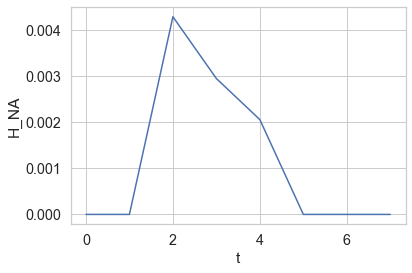

In [50]:
plt.plot(range(num_years), H_NA)
plt.xlabel('t')
plt.ylabel('H_NA')
plt.show()

Оценка Нельсона – Аалена не персонализирована, т.е. для неё мы никак не использовали признаки пациентов.

Модель пропорциональных рисков Кокса (Cox Proportional Hazard Model, CPHM) моделирует отношение риска для пациента к среднему риску по всем пациентам для данного момента времени. Поскольку это отношение рисков – положительное число, его обычно моделируют как $e^{Xw}$, где $X$ – признаки пациентов, $w$ – обучаемый вектор весов. Таким образом,

$$\hat H_{Cox}(x, t) = \hat H_{NA}(t)e^{xw}.$$

Обратите внимание, что в линейной части CPHM не используют свободный член: в некотором смысле его роль играет $\hat H_{NA}(t)$.

Вероятность заболеть ровно в момент $t$ – это произведение вероятности не заболеть до момента $t$ на вероятность заболеть в момент $t$ при условии здоровья до момента $t$. Таким образом, функция правдоподобия имеет вид

$$L = \prod_{i=1}^N \left[(\hat H_{NA}(T_i)e^{x_iw})^{y_i}(1 - \hat H_{NA}(T_i)e^{x_iw})^{1-y_i}\prod_{t=0}^{T_i-1}\left(1-\hat H_{NA}(t)e^{x_iw}\right)\right],$$

где $T_i$ – момент последней записи, $i$-го пациента.
Максимизация правдоподобия эквивалентна минимизации «минус» нормированного логарифма правдоподобия.

$$\mathcal L = -\frac{1}{N}\log L = -\frac{1}{N}\sum_{i=1}^N\left[y_i\left(\log \hat H_{NA}(T_i) + x_iw\right) + (1-y_i)\left(\log (1-\hat H_{NA}(T_i) e^{x_iw})\right) + \sum_{t=0}^{T_i - 1}\log(1-\hat H_{NA}(t)e^{x_iw})\right]$$

$$\nabla_w\mathcal L = \frac{1}{N}\sum_{i=1}^N\left[-x_iy_i + (1-y_i)\frac{\hat H_{NA}(T_i)e^{x_iw}x_i}{1-\hat H_{NA}(T_i)e^{x_iw}} + \sum_{t=0}^{T_i-1}\frac{\hat H_{NA}(t)e^{x_iw}x_i}{1-\hat H_{NA}(t)e^{x_iw}}\right]$$

Минимизировать $\mathcal L$ можно градиентным спуском, итеративно применяя формулу

$$w:= w - \eta \nabla_w\mathcal L - \eta Cw$$

где $\eta > 0$ — размер шага (learning rate), $C\geq 0$ — коэффициент регуляризации.




**Задание 8** Cox Proportional Hazard Model (CPHM) (3 балла).

 Реализуйте градиентный спуск и примените его к модели CPHM.

В качестве критерия останова мы предлагаем использовать следующие условия:
 - евклидова норма разности текущего и нового векторов весов стала меньше, чем 1e-4
 - ограничение на число итераций (например, 10000)
 
Для начальной инициализации весов нужно сравнить следующие подходы:
 - нулевая начальная инициализация
 - случайная
 
Выполните следующие пункты и прокомментируйте полученные результаты:
- Рассмотрите как влияет размер шага на сходимость (попробуйте не менее 5-ти различных значений).
- Рассмотрите регуляризованную модель (не менее 5-ти различных коэффициентов регуляризации), которая описана выше, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на скорость сходимости и качество (под качеством во всех случаях подразумевается значение исходного, нерегуляризованного функционала).
- Исследуйте качество оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).
- Влияет ли выбор начальной инициализации весов на скорость и качество?

В каждом пункте требуется построить необходимые графики скорости/качества и дать исчерпывающие выводы.


Метод градиентного спуска может быть весьма трудозатратен в случае большого размера обучающей выборки. Поэтому обычно используют метод стохастического градиентного спуска, где на каждой итерации выбирается случайный объект из обучающей выборки и обновление весов происходит сразу по этому объекту.

**Задание 9** SGD (1 балл)

Реализуйте метод стохастического градиентного спуска (sgd). В этом случае вы можете выбрать наиболее удачный функционал, исходя из предыдущего пункта (с регуляризацией, без), а также схему начальной инициализации весов.

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

Посмотрите как влияет размер шага на сходимость (попробуйте 4-5 различных значений)
Исследуйте качество оптимизируемого функционала в зависимости от номера итерации
Выберите лучший размер шага.

В каждом пункте сделайте исчерпывающие выводы, подкреплённые графиками.

Между обновлением вектора весов по всей выборке и на одном объекте есть промежуточный подход — выбирать некоторое случайное подмножество объектов и обновлять веса по нему. Такой подход называется mini-batch. Мы не будем реализовывать этот подход в данной работе, однако иногда его бывает осмысленно использовать на практике. 

Один из недостатков sgd состоит в том, что он может не доходить до локального оптимального решения, а осциллировать в окрестности. 

![](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

Для решения этой проблемы существуют методы, позволяющие устранить этот недостаток, а также ускорить сходимость. Рассмотрим некоторые из них.

![](http://nghenglim.github.io/images/2015061300.png)

### Momentum

Этот метод позволяет направить sgd в нужной размерности и уменьшить осцилляцию. 

В общем случае он будет выглядеть следующим образом: 

$$ v_t = \gamma v_{t - 1} + \eta \nabla_{w}{J(w)}$$
$$ w = w - v_t$$

где

 - $w$ — вектор параметров
 - $J$ — оптимизируемый функционал
 - $\gamma$ — momentum term (обычно выбирается 0.9)
 
### Adagrad 

Одной из сложностей является выбор размера шага (*learning rate*). Основное отличие данного метода от SGD состоит в том что размер шага определяется для каждого параметра индивидуально. Этот метод хорошо работает с разреженным данным большого объема. 

Обозначим градиент по параметру $w_i$ на итерации $t$ как $g_{t,i} = \nabla_{w}J(w_i)$. 

В случае sgd обновление параметра $w_i$ будет выглядеть следующим образом:

$$ w_{t+1, i} = w_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ нормируется на посчитанные ранее градиенты для данного параметра:

$$ w_{t+1, i} = w_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i}$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $w_{i}$ до $t$-ой итерации. $\varepsilon$ — гиперпараметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом (здесь $\odot$ — матричное умножение):

$$ w_{t+1} = w_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

### Adadelta

Adadelta, в отличии от Adagrad, рассматривает не все предыдущие значения градиентов, а только последние $k$. Кроме того, сумма градиентов определяется как уменьшающееся среднеее всех предыдущих квадратов градиентов. Текущее среднее $E[g^2]_t$ на итерации $t$ будет вглядеть следующим образом:

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 $$

здесь $\gamma$ аналогична гиперпараметру из метода Momentum.

Тогда обновление весов можно записать следующим образом:

$$ w_{t+1} = w_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Перепишем это немного по-другому:

$$ w_{t+1} = w_{t} + \Delta w_t$$ 
$$\Delta w_t = - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Аналогично среднему для градиентов определим среднее для параметров $w$:

$$ E[\Delta w^2]_t = \gamma E[\Delta w^2]_{t-1} + (1-\gamma)\Delta w^2 $$

Введем обозначение $RMS[p]_t = \sqrt{E[p]_t + \varepsilon}$

Тогда Adadelta выглядит следующим образом:

$$\Delta w_t = - \dfrac{RMS[\Delta w^2]}{RMS[ga^2]} g_t $$ 
$$ w_{t+1} = w_{t} + \Delta w_t$$ 


Более подробно об этих и других способах оптимизации можно прочитать:
 - [здесь](http://sebastianruder.com/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) очень хорошее описание различных способов оптимизации, в этом задании мы опираемся на терминологию из данной статьи
 - статья про [momentum](https://pdfs.semanticscholar.org/97da/c94ffd7a7ac09a4218848300cc7e98569d77.pdf)
 - оригинальная статья про [adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
 - оригинальная статья про [adadelta](http://arxiv.org/pdf/1212.5701v1.pdf)
 - википедия про [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) и [adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad)
 - [визуализация](http://imgur.com/a/Hqolp) разных способов оптимизации

**Задание 10** Реализуйте метод оптимизации *Momentum* (0.5 балла) и 

**Задание 11** Реализуйте один из *Adagrad*/*Adadelta* (1 балл).

В заданиях 10, 11:
- Сравните оба метода с классическим sgd с точки зрения скорости сходимости.
- Посмотрите как значение гиперпараметра $\gamma$ влияет на скорость сходимости и качество в методе *Momentum*.

Постройте графики и опишите полученные результаты.

Дало ли преимущество использование адаптивного шага в методе *Adagrad*/*Adadelta*?

**Задание 12** Предсказание с помощью CPHM, интерфейс sklearn (1 балл)


Чтобы сравнить CPHM с предыдущими моделями, надо научиться предсказывать целевую переменную. С помощью значений персональной функции риска $\hat H_{Cox}(x, t)$ можно выразить вероятность того, что человек в течение 5 лет не заболеет при условии, что он не прекратит участие в эксперементе по другим причинам. Вероятность того, что человек не прекратит участие в эксперименте, оставаясь здоровым, также можно оценить из данных.

Реализуйте модель CPHM, унаследовав класс модели от [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator). Модель должна поддерживать методы fit, predict, predict_proba. Это вам позволит в следующем задании её откалибровать. При тестировании модели следует передать то время, через которое вас интересует состояние пациента (в случае конкурса, 5 лет).




**Задание 13** Калибровка классификатора (2 балла)

Сравнительно простой способ уточнить оценки вероятности и уменьшить logloss -- откалибровать модель. Вообще говоря, сравнивать между собой некалиброванные модели по logloss некорректно: хорошая модель с нарушенной калибровкой может иметь сколь угодно большое значение logloss.

Идея калибровки состоит в том, чтобы подобрать простое преобразование, которое превратит выходы моделей в вероятности принадлежности классам.

Есть несколько известных методов калибровки:
 - Калибровка Платта.
 - Изотоническая регрессия.

Обратите внимание, что преобразование необходимо обучать на отложенной выборке (то есть классификатор и калибровка должны обучаться на разных подмножествах данных), иначе можно переобучиться. Калибровку можно применять к любым классификаторам (где это разумно и необходимо), особенно к тем, которые не оптимизируют logloss явно.

Для калибровки классификатора в sklearn возможны два подхода:
 - взять уже обученный классификатор и откалибровать его на отложенной выборке
 - откалибровать по кросс-валидации: калибровочному классификатору передается вся обучающая выборка, которая внутри разбивается на обучающую и калибровочную, после чего происходит усреднение вероятностей по фолдам.
 
Подробнее об этом можно прочитать в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV). Также [здесь](https://jmetzen.github.io/2015-04-14/calibration.html) можно узнать подробности о калибровке в sklearn от автора.

Используйте оба описанных выше подхода (калибровку Платта и изотоническую регрессию) для калибровки моделей, построенных в лабораторной работе. Для каждой модели постройте график, на котором будут изображены [калибровочные кривые](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html): идеальная, исходного классификатора, а также для каждого из методов. Калибровочная кривая строится путем упорядочения всех объектов по предсказанному значению, которые разбиваются на бины. По оси OX откладывается среднее предсказанное значение вероятности по бину, а по OY — доля положительных примеров. В случае идеальных вероятностей это будет прямая.
 


Выполнив задания, не забудьте отправить решение в [конкурс](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2021)

**Выводы** (0.5 балла)

- Какие есть достоинства и недостатки у рассмотренных в лабораторной работе моделей?
- Какие модели сильно улучшили свой logloss после калибровки, а какие - нет? Почему так произошло?
- Какие из рассмотренных методов могут обучиться на маленьких датасетах? А какие применимы для очень больших датасетов? Какие проблемы могут возникнуть при применении к большим датасетам и как их можно решить?
